In [1]:
### importing necessary packages 

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, Concatenate, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
#from google.colab import drive
import seaborn as sns
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/Case study 2')

In [4]:
os.listdir()

['dataset.csv', 'output', 'images', 'mask']

In [5]:
### importing our dataset

dataset = pd.read_csv('dataset.csv')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     494 non-null    int64 
 1   Unnamed: 0.1   494 non-null    int64 
 2   image          494 non-null    object
 3   mask           494 non-null    object
 4   column_output  494 non-null    object
 5   table_output   494 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.3+ KB


In [6]:
dataset.drop(['Unnamed: 0.1'], axis = 1, inplace = True)

In [7]:
dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
dataset.head()

,image,mask,column_output,table_output
0,Case study 2/images/10.1.1.1.2006_3.jpeg,Case study 2/mask/10.1.1.1.2006_3.xml,Case study 2/output/10.1.1.1.2006_3/column_mas...,Case study 2/output/10.1.1.1.2006_3/table_mask...
1,Case study 2/images/10.1.1.1.2013_63.jpeg,Case study 2/mask/10.1.1.1.2013_63.xml,Case study 2/output/10.1.1.1.2013_63/column_ma...,Case study 2/output/10.1.1.1.2013_63/table_mas...
2,Case study 2/images/10.1.1.1.2013_64.jpeg,Case study 2/mask/10.1.1.1.2013_64.xml,Case study 2/output/10.1.1.1.2013_64/column_ma...,Case study 2/output/10.1.1.1.2013_64/table_mas...
3,Case study 2/images/10.1.1.1.2014_4.jpeg,Case study 2/mask/10.1.1.1.2014_4.xml,Case study 2/output/10.1.1.1.2014_4/column_mas...,Case study 2/output/10.1.1.1.2014_4/table_mask...
4,Case study 2/images/10.1.1.1.2014_6.jpeg,Case study 2/mask/10.1.1.1.2014_6.xml,Case study 2/output/10.1.1.1.2014_6/column_mas...,Case study 2/output/10.1.1.1.2014_6/table_mask...


### For data pre processing we have to - 
#### Resize our images to 1024*1024
#### Normalize the image

In [9]:
### reference - https://www.tensorflow.org/api_docs/python/tf/io/read_file

def load_image(image, col_mask, tab_mask):
    '''this function will resize the images to 1024*1024
       and normalize every pixel by dividing by 255'''
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [1024,1024])
    image = tf.cast(image, tf.float32) / 255.0
    col_mask = tf.io.read_file(col_mask)
    col_mask = tf.image.decode_jpeg(col_mask, channels=1)
    col_mask = tf.image.resize(col_mask, [1024,1024])
    col_mask = tf.cast(col_mask, tf.float32) / 255.0 
    tab_mask = tf.io.read_file(tab_mask)
    tab_mask = tf.image.decode_jpeg(tab_mask, channels = 1)
    tab_mask = tf.image.resize(tab_mask, [1024,1024])
    tab_mask = tf.cast(tab_mask, tf.float32) / 255.0
    return image, {"column_mask" : col_mask, "table_mask" : tab_mask}

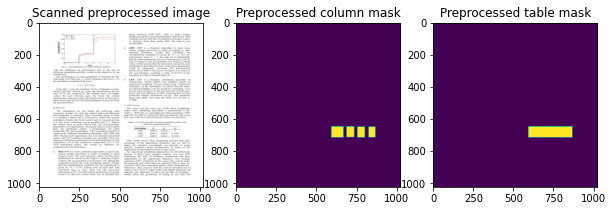

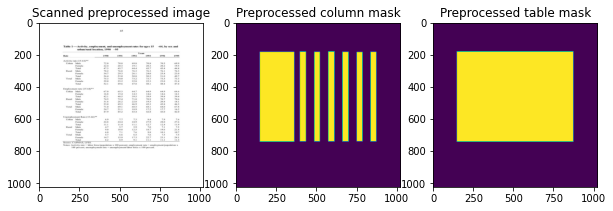

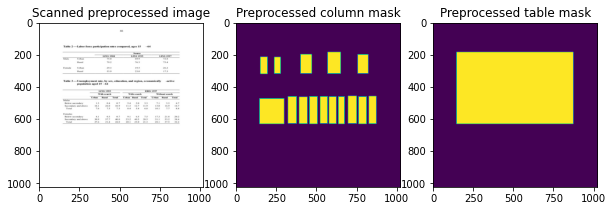

In [10]:
#os.chdir('D:/Applied AI/')
os.chdir('/content/drive/My Drive/')
for i in range(3) :
    image = dataset['image'][i]
    col_mask = dataset['column_output'][i]
    tab_mask = dataset['table_output'][i]
    image, mask = load_image(image, col_mask, tab_mask)
    plt.figure(figsize = (10,6))
    plt.subplot(131)
    plt.title("Scanned preprocessed image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.subplot(132)
    plt.title("Preprocessed column mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask["column_mask"]))
    plt.subplot(133)
    plt.title("Preprocessed table mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask["table_mask"]))
    plt.show()

### TableNet Model

In [ ]:
#X_input = Input(shape = (1024,1024,3), name = "input_layer")

resnet50 = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (1024,1024,3))


In [ ]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name = "table_mask"):
        super().__init__(name = name)
        self.conv1 = Conv2D(kernel_size = 1, filters = 256, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 0))
        self.upsamp1 = UpSampling2D(size = (2,2), interpolation = 'bilinear')
        self.concat1 = Concatenate(axis = -1)
        self.upsamp2 = UpSampling2D(size = (2,2), interpolation = 'bilinear')
        self.upsamp3 = UpSampling2D(size = (4,4), interpolation = 'bilinear')
        self.convtrans = Conv2DTranspose(filters = 2, kernel_size = (2,2),strides = 2)
        
    def call(self, X):
        x_inp, resnet_output = X[0], X[1]
        x_con = self.conv1(resnet_output)
        x_con = self.concat1([x_con, x_inp])
        x_con = self.upsamp1(x_con)
        x_con = self.upsamp2(x_con)
        x_con = self.upsamp3(x_con)
        x_con = self.convtrans(x_con)
        
        return x_con

In [12]:
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name = "column_mask"):
        super().__init__(name = name)
        self.conv1 = Conv2D(kernel_size = 1, filters = 256, activation = 'relu', kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))
        self.drop = Dropout(rate = 0.8)
        self.conv2 = Conv2D(kernel_size = 1, filters = 256, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))
        self.upsamp1 = UpSampling2D(size = (2,2), interpolation = 'bilinear')
        self.concat1 = Concatenate(axis = -1)
        self.upsamp2 = UpSampling2D(size = (2,2), interpolation = 'bilinear')
        self.upsamp3 = UpSampling2D(size = (4,4), interpolation = 'bilinear')
        self.convtrans = Conv2DTranspose(filters = 2, kernel_size = (2,2), strides = 2)
        
    def call(self, X):
        x_inp, resnet_output = X[0], X[1]
        x_con = self.conv1(resnet_output)
        x_con = self.drop(x_con)
        x_con = self.conv2(x_con)
        x_con = self.concat1([x_con, x_inp])
        x_con = self.upsamp1(x_con)
        x_con = self.upsamp2(x_con)
        x_con = self.upsamp3(x_con)
        x_con = self.convtrans(x_con)
        
        return x_con

In [13]:
### TableNet
tf.keras.backend.clear_session()
X_input = Input(shape = (1024,1024,3), name = "input_layer")

resnet_50 = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_tensor = X_input)

### extracting output of the last layer

output = resnet_50.output

for layers in resnet_50.layers :
  layers.trainable = False  

X = Conv2D(kernel_size = 1, filters = 512, name = "conv6_block1", activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.004))(output)
X = Dropout(0.8)(X)
X = Conv2D(kernel_size = 1, filters = 512, name = "conv7_block1", activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.004))(X)
X = Dropout(0.8)(X)

X_comb = (X, output)

table_output = table_decoder()(X_comb)
column_output = column_decoder()(X_comb)

In [14]:
model = Model(inputs = X_input, outputs = [column_output, table_output], name = "tablenet_resnet")

In [16]:
model.summary()

Model: "tablenet_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_layer[0][0]                
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________

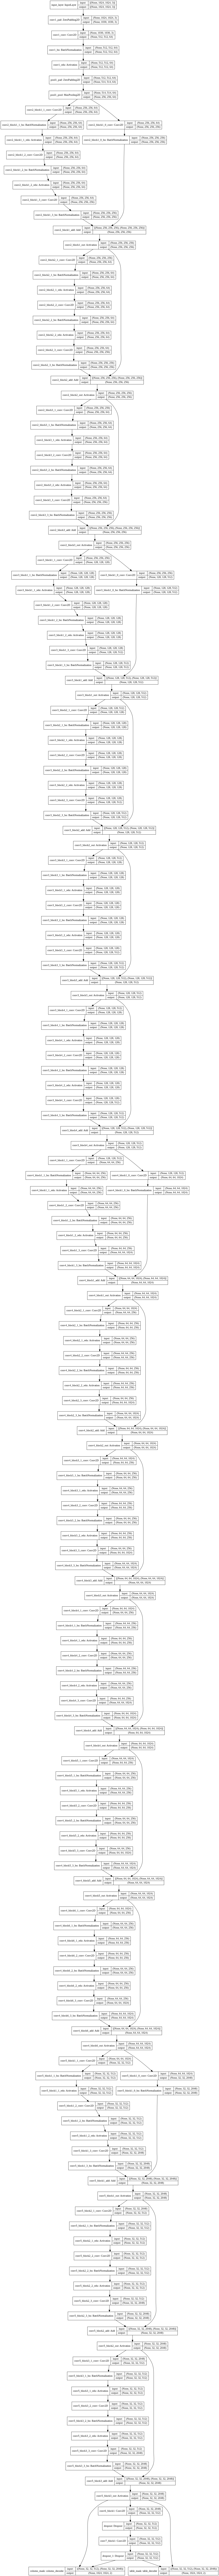

In [17]:
tf.keras.utils.plot_model(model, to_file = "tablenet_resnet.png", show_shapes = True, show_layer_names = True, rankdir = 'TB')

In [15]:
final_data = dataset.drop(['mask'], axis = 1)

In [16]:
final_data.head()

,image,column_output,table_output
0,Case study 2/images/10.1.1.1.2006_3.jpeg,Case study 2/output/10.1.1.1.2006_3/column_mas...,Case study 2/output/10.1.1.1.2006_3/table_mask...
1,Case study 2/images/10.1.1.1.2013_63.jpeg,Case study 2/output/10.1.1.1.2013_63/column_ma...,Case study 2/output/10.1.1.1.2013_63/table_mas...
2,Case study 2/images/10.1.1.1.2013_64.jpeg,Case study 2/output/10.1.1.1.2013_64/column_ma...,Case study 2/output/10.1.1.1.2013_64/table_mas...
3,Case study 2/images/10.1.1.1.2014_4.jpeg,Case study 2/output/10.1.1.1.2014_4/column_mas...,Case study 2/output/10.1.1.1.2014_4/table_mask...
4,Case study 2/images/10.1.1.1.2014_6.jpeg,Case study 2/output/10.1.1.1.2014_6/column_mas...,Case study 2/output/10.1.1.1.2014_6/table_mask...


In [17]:
X_train , X_test = train_test_split(final_data, test_size = 0.10)

In [18]:
X_train.shape, X_test.shape

((444, 3), (50, 3))

In [19]:
training_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_train['image'].values, tf.string),
                                                        tf.cast(X_train['column_output'].values, tf.string),
                                                        tf.cast(X_train['table_output'].values, tf.string),)))

In [20]:
testing_dataset = (tf.data.Dataset.from_tensor_slices((tf.cast(X_test['image'].values, tf.string),
                                                        tf.cast(X_test['column_output'].values, tf.string),
                                                        tf.cast(X_test['table_output'].values, tf.string),)))

In [21]:
train = training_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = testing_dataset.map(load_image)

In [22]:
BATCH_SIZE = 1
BUFFER_SIZE = 10
train_steps = len(X_train) // BATCH_SIZE
vaildation_steps = len(X_test) // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [26]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 1024, 1024, 3), {column_mask: (None, 1024, 1024, 1), table_mask: (None, 1024, 1024, 1)}), types: (tf.float32, {column_mask: tf.float32, table_mask: tf.float32})>

In [23]:
model.load_weights('best_model_cs2_final_resnet.h5')

In [27]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_model_cs2_final_resnet.h5', save_weights_only=True, save_best_only=True, mode = 'min', verbose=1),
             tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience=3, min_lr = 0.0000001, verbose=1)]

In [28]:
losses = {"column_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          "table_mask" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}

loss_weights = {"column_mask" : 1.0, "table_mask" : 1.0}

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
model.compile(optimizer = optimizer,loss = losses, metrics = ['accuracy'], loss_weights=loss_weights)

In [34]:
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs = 10, validation_data=test_dataset,validation_steps=vaildation_steps, callbacks=callbacks)

Epoch 1/10
444/444 [==============================] - 94s 212ms/step - loss: 0.4918 - column_mask_loss: 0.2080 - table_mask_loss: 0.2682 - column_mask_accuracy: 0.8819 - table_mask_accuracy: 0.8770 - val_loss: 0.5753 - val_column_mask_loss: 0.2643 - val_table_mask_loss: 0.2971 - val_column_mask_accuracy: 0.8388 - val_table_mask_accuracy: 0.8483

Epoch 00001: val_loss did not improve from 0.56684
Epoch 2/10
444/444 [==============================] - 96s 215ms/step - loss: 0.4895 - column_mask_loss: 0.2066 - table_mask_loss: 0.2706 - column_mask_accuracy: 0.8807 - table_mask_accuracy: 0.8759 - val_loss: 0.5782 - val_column_mask_loss: 0.2701 - val_table_mask_loss: 0.2971 - val_column_mask_accuracy: 0.8322 - val_table_mask_accuracy: 0.8482

Epoch 00002: val_loss did not improve from 0.56684
Epoch 3/10
444/444 [==============================] - 96s 216ms/step - loss: 0.4840 - column_mask_loss: 0.2070 - table_mask_loss: 0.2673 - column_mask_accuracy: 0.8803 - table_mask_accuracy: 0.8787 - va

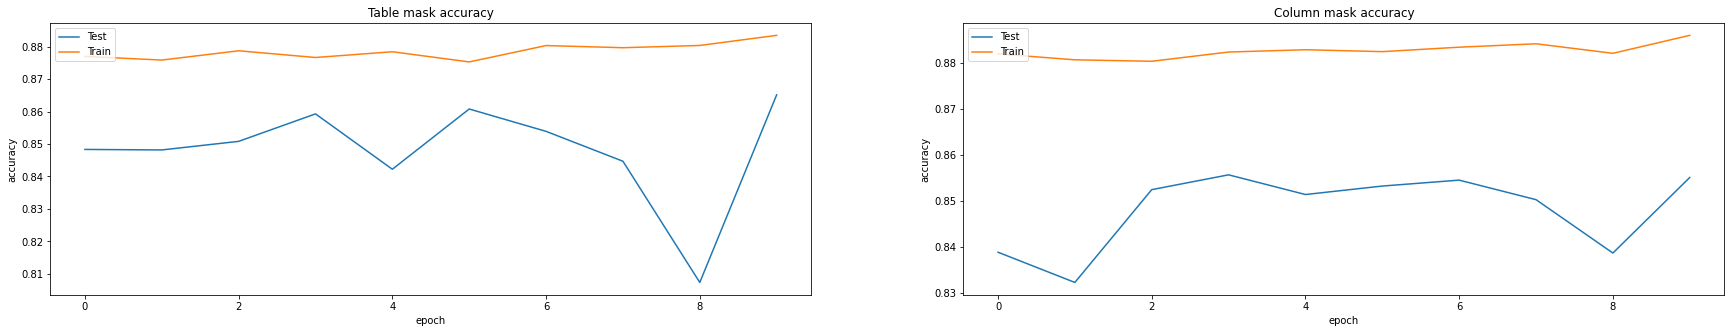

In [35]:
plt.figure(figsize = (30,5))
plt.subplot(121)
plt.plot(history.history['val_table_mask_accuracy'])
plt.plot(history.history['table_mask_accuracy'])
plt.title('Table mask accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Test', 'Train'], loc = 'upper left')

plt.subplot(122)
plt.plot(history.history['val_column_mask_accuracy'])
plt.plot(history.history['column_mask_accuracy'])
plt.title('Column mask accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Test', 'Train'], loc = 'upper left')

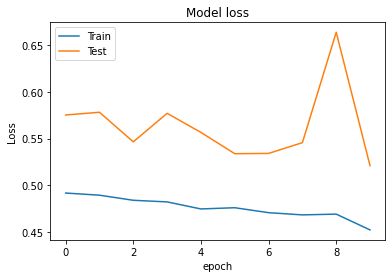

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')

In [24]:
def create_mask(col_pred_mask, table_pred_mask):
  col_pred_mask = tf.argmax(col_pred_mask, axis = -1)
  col_pred_mask = col_pred_mask[..., np.newaxis]
  table_pred_mask = tf.argmax(table_pred_mask, axis = -1)
  table_pred_mask = table_pred_mask[..., np.newaxis]
  return col_pred_mask[0], table_pred_mask[0]

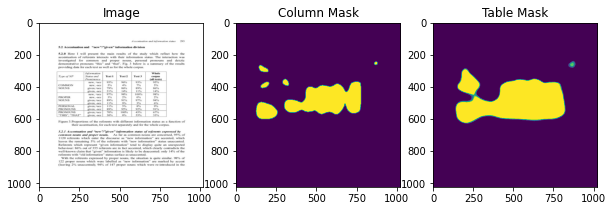

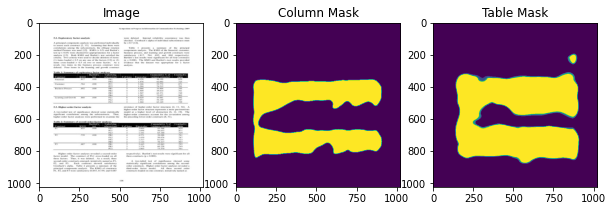

In [26]:
number = 2

for image, mask in test.take(number) :
  image = image[np.newaxis, ...]
  col_mask, tab_mask = model.predict(image)
  col_mask, tab_mask = create_mask(col_mask, tab_mask)
  plt.figure(figsize = (10,6))
  plt.subplot(131)
  plt.title('Image')
  image = tf.squeeze(image)
  plt.imshow(image)
  plt.subplot(132)
  plt.title('Column Mask')
  plt.imshow(tf.keras.preprocessing.image.array_to_img(col_mask))
  plt.subplot(133)
  plt.title('Table Mask')
  plt.imshow(tf.keras.preprocessing.image.array_to_img(tab_mask))
  plt.show()

# Precision, Recall and F1

In [27]:
table_mask = []
column_mask = []
pred_table_mask = []
pred_column_mask = []


In [28]:
for image, mask in test :
  table_mask.append(mask['table_mask'])
  column_mask.append(mask['column_mask'])
  col, tab = model.predict(image[np.newaxis,:,:,:])
  col_mask, tab_mask = create_mask(col, tab)
  pred_column_mask.append(col_mask)
  pred_table_mask.append(tab_mask)

In [27]:
def precision(mask, predicted_mask):
  m = tf.keras.metrics.Precision()
  m.update_state(mask, predicted_mask)
  return m.result().numpy()

In [30]:
p1 = precision(column_mask, pred_column_mask)

In [31]:
print ("*"*100)
print ("Precision for test points for column mask is {}".format(p1))
print ("*"*100)

****************************************************************************************************
Precision for test points for column mask is 0.7667928338050842
****************************************************************************************************


In [32]:
p2 = precision(table_mask, pred_table_mask)

In [33]:
print ("*"*100)
print ("Precision for test points for table mask is {}".format(p2))
print ("*"*100)

****************************************************************************************************
Precision for test points for table mask is 0.7791913747787476
****************************************************************************************************


In [28]:
def recall(mask, predicted_mask):
  m = tf.keras.metrics.Recall()
  m.update_state(mask, predicted_mask)
  return m.result().numpy()

In [35]:
r1 = recall(column_mask, pred_column_mask)
print ("*"*100)
f1 = 2*(r1*p1)/(r1+p1)
print ("F1 score for test points for column mask is {}".format(f1))
r2 = recall(table_mask, pred_table_mask)
f2 = 2*(p2*r2)/(p2+r2)
print ("F1 score for test points for table mask is {}".format(f2))
print ("*"*100)

****************************************************************************************************
F1 score for test points for column mask is 0.5347865310974264
F1 score for test points for table mask is 0.6876358818186675
****************************************************************************************************


In [36]:
for image, mask in test.take(1):
  col , tab = model.predict(image[np.newaxis, :, :, :])
  col_mask, tab_mask = create_mask(col, tab)

  im = tf.keras.preprocessing.image.array_to_img(image)
  im.save("original_image_res.bmp")

  im = tf.keras.preprocessing.image.array_to_img(col_mask)
  im.save("col_mask_res.bmp")

  im = tf.keras.preprocessing.image.array_to_img(tab_mask)
  im.save("tab_mask_res.bmp")

## Calculating Precision and Recall for all the 494 files

In [25]:
table_mask = []
column_mask = []
pred_table_mask = []
pred_column_mask = []

for image, mask in test :
  table_mask.append(mask['table_mask'])
  column_mask.append(mask['column_mask'])
  col, tab = model.predict(image[np.newaxis,:,:,:])
  col_mask, tab_mask = create_mask(col, tab)
  pred_column_mask.append(col_mask)
  pred_table_mask.append(tab_mask)

for image, mask in train :
  table_mask.append(mask['table_mask'])
  column_mask.append(mask['column_mask'])
  col, tab = model.predict(image[np.newaxis,:,:,:])
  col_mask, tab_mask = create_mask(col, tab)
  pred_column_mask.append(col_mask)
  pred_table_mask.append(tab_mask)

In [40]:

pr = []
for i,j in zip(column_mask, pred_column_mask):
  p = precision(i,j)
  pr.append(p)

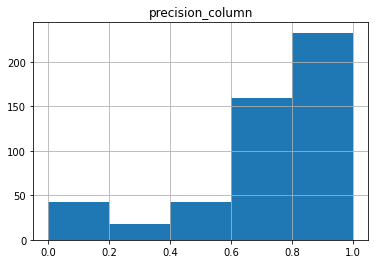

In [41]:
df = pd.DataFrame()
df['precision_column'] = pr
hist = df.hist(bins = 5)

In [42]:
df['precision_column'].describe()

count    494.000000
mean       0.718997
std        0.268814
min        0.000000
25%        0.650023
50%        0.790738
75%        0.903697
max        1.000000
Name: precision_column, dtype: float64

### Observation - About 75% of the column masks have precision around 0.9 

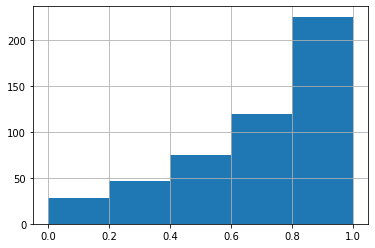

In [29]:
df = pd.DataFrame()
pr_table = []
for i,j in zip(table_mask, pred_table_mask):
  p = precision(i,j)
  pr_table.append(p)

df['precision_table'] = pr_table
hist = df.precision_table.hist(bins = 5)

In [30]:
df['precision_table'].describe()

count    494.000000
mean       0.696271
std        0.265120
min        0.000000
25%        0.547237
50%        0.774035
75%        0.904110
max        1.000000
Name: precision_table, dtype: float64

### Observation - Around 75 % of the table masks have precision around 0.90

In [31]:
recall_column = []
for i,j in zip(column_mask, pred_column_mask):
  r = recall(i,j)
  recall_column.append(r)

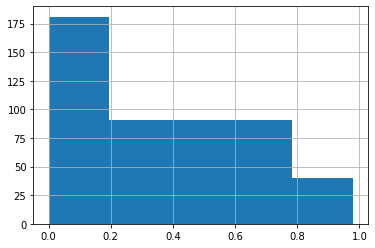

In [32]:
df['recall_column'] = recall_column
hist = df['recall_column'].hist(bins = 5)

In [33]:
df['recall_column'].describe()

count    494.000000
mean       0.360801
std        0.273364
min        0.000000
25%        0.119623
50%        0.312488
75%        0.605346
max        0.979186
Name: recall_column, dtype: float64

### Observation - 75% of the column masks have recall around 0.60

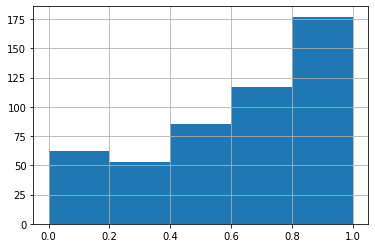

In [34]:
recall_table = []
for i,j in zip(table_mask, pred_table_mask):
  r = recall(i,j)
  recall_table.append(r)

df['recall_table'] = recall_table
hist = df['recall_table'].hist(bins = 5)

In [35]:
df['recall_table'].describe()

count    494.000000
mean       0.626536
std        0.293536
min        0.000000
25%        0.429758
50%        0.701756
75%        0.865413
max        1.000000
Name: recall_table, dtype: float64

### Observation - Around 75 % of the table masks have recall around 0.86

## Extracting textual data from the image

In [2]:
os.chdir("D:/Applied AI/")

In [3]:
img = Image.open("original_image_res.bmp")

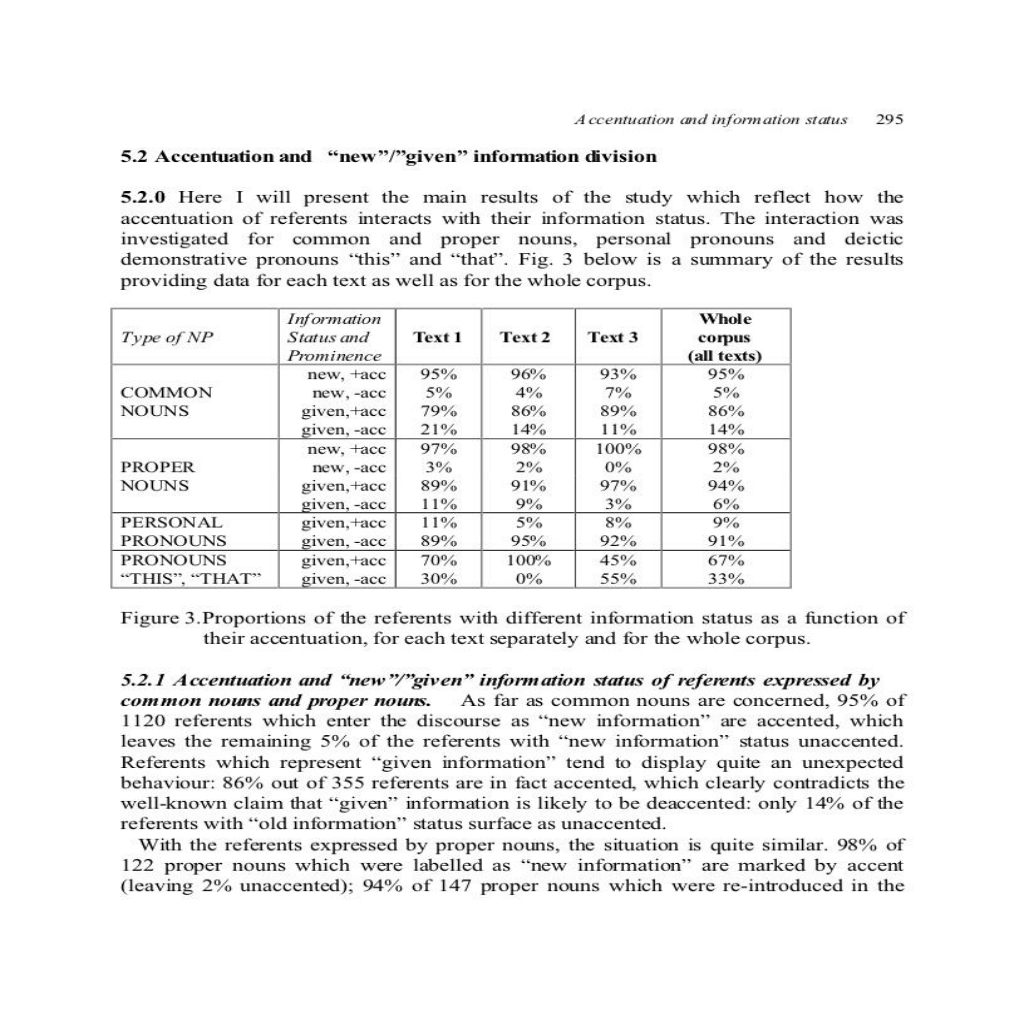

In [4]:
img

In [5]:
table_mask = Image.open("tab_mask_res.bmp")

In [6]:
img.putalpha(table_mask)

In [7]:
img.save("output_alpha_res.png")

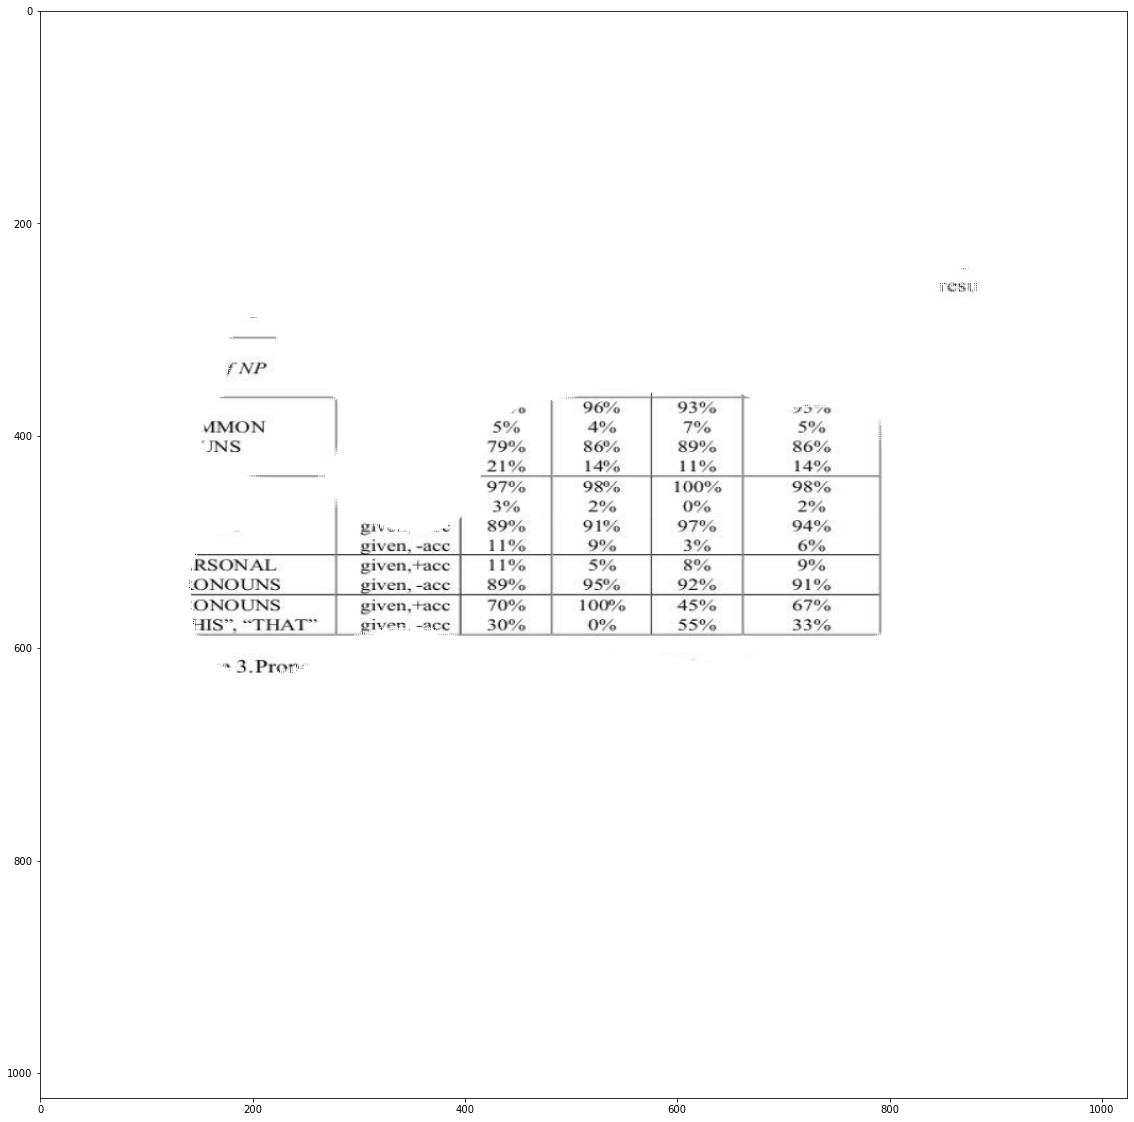

In [8]:
image = cv2.imread("output_alpha_res.png", cv2.IMREAD_UNCHANGED)
plt.figure(figsize = (40,20))
plt.imshow(image)

In [9]:
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"

In [10]:
def image_to_text(img_name):
    text = pytesseract.image_to_string(Image.open(img_name))
    return text

In [11]:
print (image_to_text("output_alpha_res.png"))

 

 

 

 

 

 

 

¢NP

0 96% 93% sore

v_IMON 5% 4% 1% 5%
“INS 79% 86% 89% 86%
21% 14% 11% 14%

97% 98% 100% 98%

3% 2% 0% 2%
gin = [{ 89% 91% 97% 94%

given,-acc | __11% 2% 3% 6%

/RSONAL given,tace [11% 5% 8% 9%
<ONOUNS given,-acc | 89% 95% 92% 91%
ONOUNS| given,tace | 70% 100% 45% 67%
HIS”, “THAT” given. -ace | 30% 0% 55% 33%

 

 

 

= 3.Prom

res

